## Projeto para competição de Kaggle 

# Import's

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical

# Preparar a informação

In [97]:
df = pd.read_csv("C:\\Users\\catar\\Desktop\\Projetos AI\\ML_houseprices\\train.csv")

In [98]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Eliminar Variáveis desnecessárias

In [100]:
df = df.drop(columns=['Id'])

Distribuição dos preços

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Figure size 600x500 with 0 Axes>

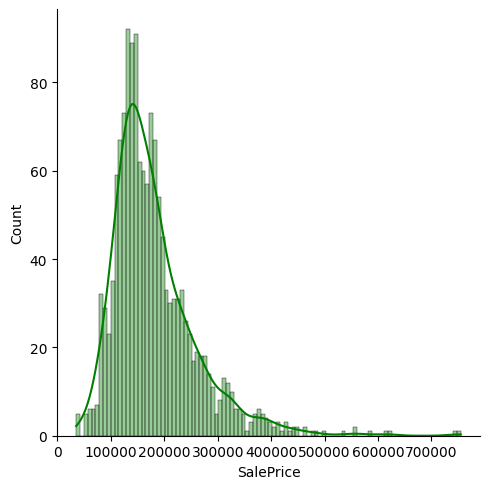

In [101]:
print(df['SalePrice'].describe())
plt.figure(figsize=(6, 5))
sn.displot(df['SalePrice'], color='g', bins=100, alpha=0.4, kde=True);

Lidar com Nulls e fazer Encoding

In [102]:
#Ordinal Encoding: Street,Alley,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual
#                  BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual
#                  Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC
#                  Fence

columns_to_encode = ['Street', 'Alley', 'LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

categories_list = [['Grvl', 'Pave'],
                   ['Grvl', 'Pave'],
                   ['IR3', 'IR2', 'IR1', 'Reg'],
                   ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
                   ['Sev', 'Mod', 'Gtl'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['No', 'Mn', 'Av', 'Gd'],
                   ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                   ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['N', 'Y'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Unf', 'RFn', 'Fin'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['N', 'P', 'Y'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['MnWw', 'GdWo', 'MnPrv', 'GdPrv']]

ordinal_encoder = OrdinalEncoder(categories= categories_list,
                                 handle_unknown='use_encoded_value',
                                 unknown_value=-1,
                                 dtype=np.int64)
#Converter para objeto para garantir compatabilidade
df[columns_to_encode] = df[columns_to_encode].astype(object)
df[columns_to_encode] = ordinal_encoder.fit_transform(df[columns_to_encode])
df


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,1,-1,3,Lvl,3,Inside,...,0,-1,-1,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,1,-1,3,Lvl,3,FR2,...,0,-1,-1,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,1,-1,2,Lvl,3,Inside,...,0,-1,-1,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,1,-1,2,Lvl,3,Corner,...,0,-1,-1,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,1,-1,2,Lvl,3,FR2,...,0,-1,-1,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,1,-1,3,Lvl,3,Inside,...,0,-1,-1,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,1,-1,3,Lvl,3,Inside,...,0,-1,2,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,1,-1,3,Lvl,3,Inside,...,0,-1,3,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,1,-1,3,Lvl,3,Inside,...,0,-1,-1,NaN,0,4,2010,WD,Normal,142125


In [103]:
#Target Encoding: MSZoning, LandContour,LotConfig,Neighborhood,Condition1,Condition2,
#                 BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,
#                 MasVnrType,Foundation,Heating,Electrical,GarageType,MiscFeature,SaleType,SaleCondition

columns_to_encode = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
           'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
           'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 
           'SaleType', 'SaleCondition']

kf = KFold(n_splits=3,shuffle=True, random_state=42)
for col in columns_to_encode:
    df[col] = df[col].fillna('Missing')
    global_mean = df.groupby(col)['SalePrice'].mean()
    for data_mean, values_to_fix in kf.split(df):
        data_mean_df, values_to_fix_df = df.iloc[data_mean], df.iloc[values_to_fix]
        target_mean = data_mean_df.groupby(col)['SalePrice'].mean()
        
        #mapeia usando target value mas caso não seja possivel, por falta de casos mapeia com a média global
        mapped_values = values_to_fix_df[col].map(target_mean)
        global_mapped_values = values_to_fix_df[col].map(global_mean)
        filled_values = mapped_values.fillna(global_mapped_values)

        df.loc[values_to_fix, col] = filled_values
    df[col] = df[col].astype(np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   float64
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int64  
 5   Alley          1460 non-null   int64  
 6   LotShape       1460 non-null   int64  
 7   LandContour    1460 non-null   float64
 8   Utilities      1460 non-null   int64  
 9   LotConfig      1460 non-null   float64
 10  LandSlope      1460 non-null   int64  
 11  Neighborhood   1460 non-null   float64
 12  Condition1     1460 non-null   float64
 13  Condition2     1460 non-null   float64
 14  BldgType       1460 non-null   float64
 15  HouseStyle     1460 non-null   float64
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [104]:
df['LotFrontage'].fillna(value=0,inplace=True)
df.dropna(inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1371 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1371 non-null   int64  
 1   MSZoning       1371 non-null   float64
 2   LotFrontage    1371 non-null   float64
 3   LotArea        1371 non-null   int64  
 4   Street         1371 non-null   int64  
 5   Alley          1371 non-null   int64  
 6   LotShape       1371 non-null   int64  
 7   LandContour    1371 non-null   float64
 8   Utilities      1371 non-null   int64  
 9   LotConfig      1371 non-null   float64
 10  LandSlope      1371 non-null   int64  
 11  Neighborhood   1371 non-null   float64
 12  Condition1     1371 non-null   float64
 13  Condition2     1371 non-null   float64
 14  BldgType       1371 non-null   float64
 15  HouseStyle     1371 non-null   float64
 16  OverallQual    1371 non-null   int64  
 17  OverallCond    1371 non-null   int64  
 18  YearBuilt    

C:\Users\catar\AppData\Local\Temp\ipykernel_18676\2601219941.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LotFrontage'].fillna(value=0,inplace=True)


# Análise de variáveis

Correlações

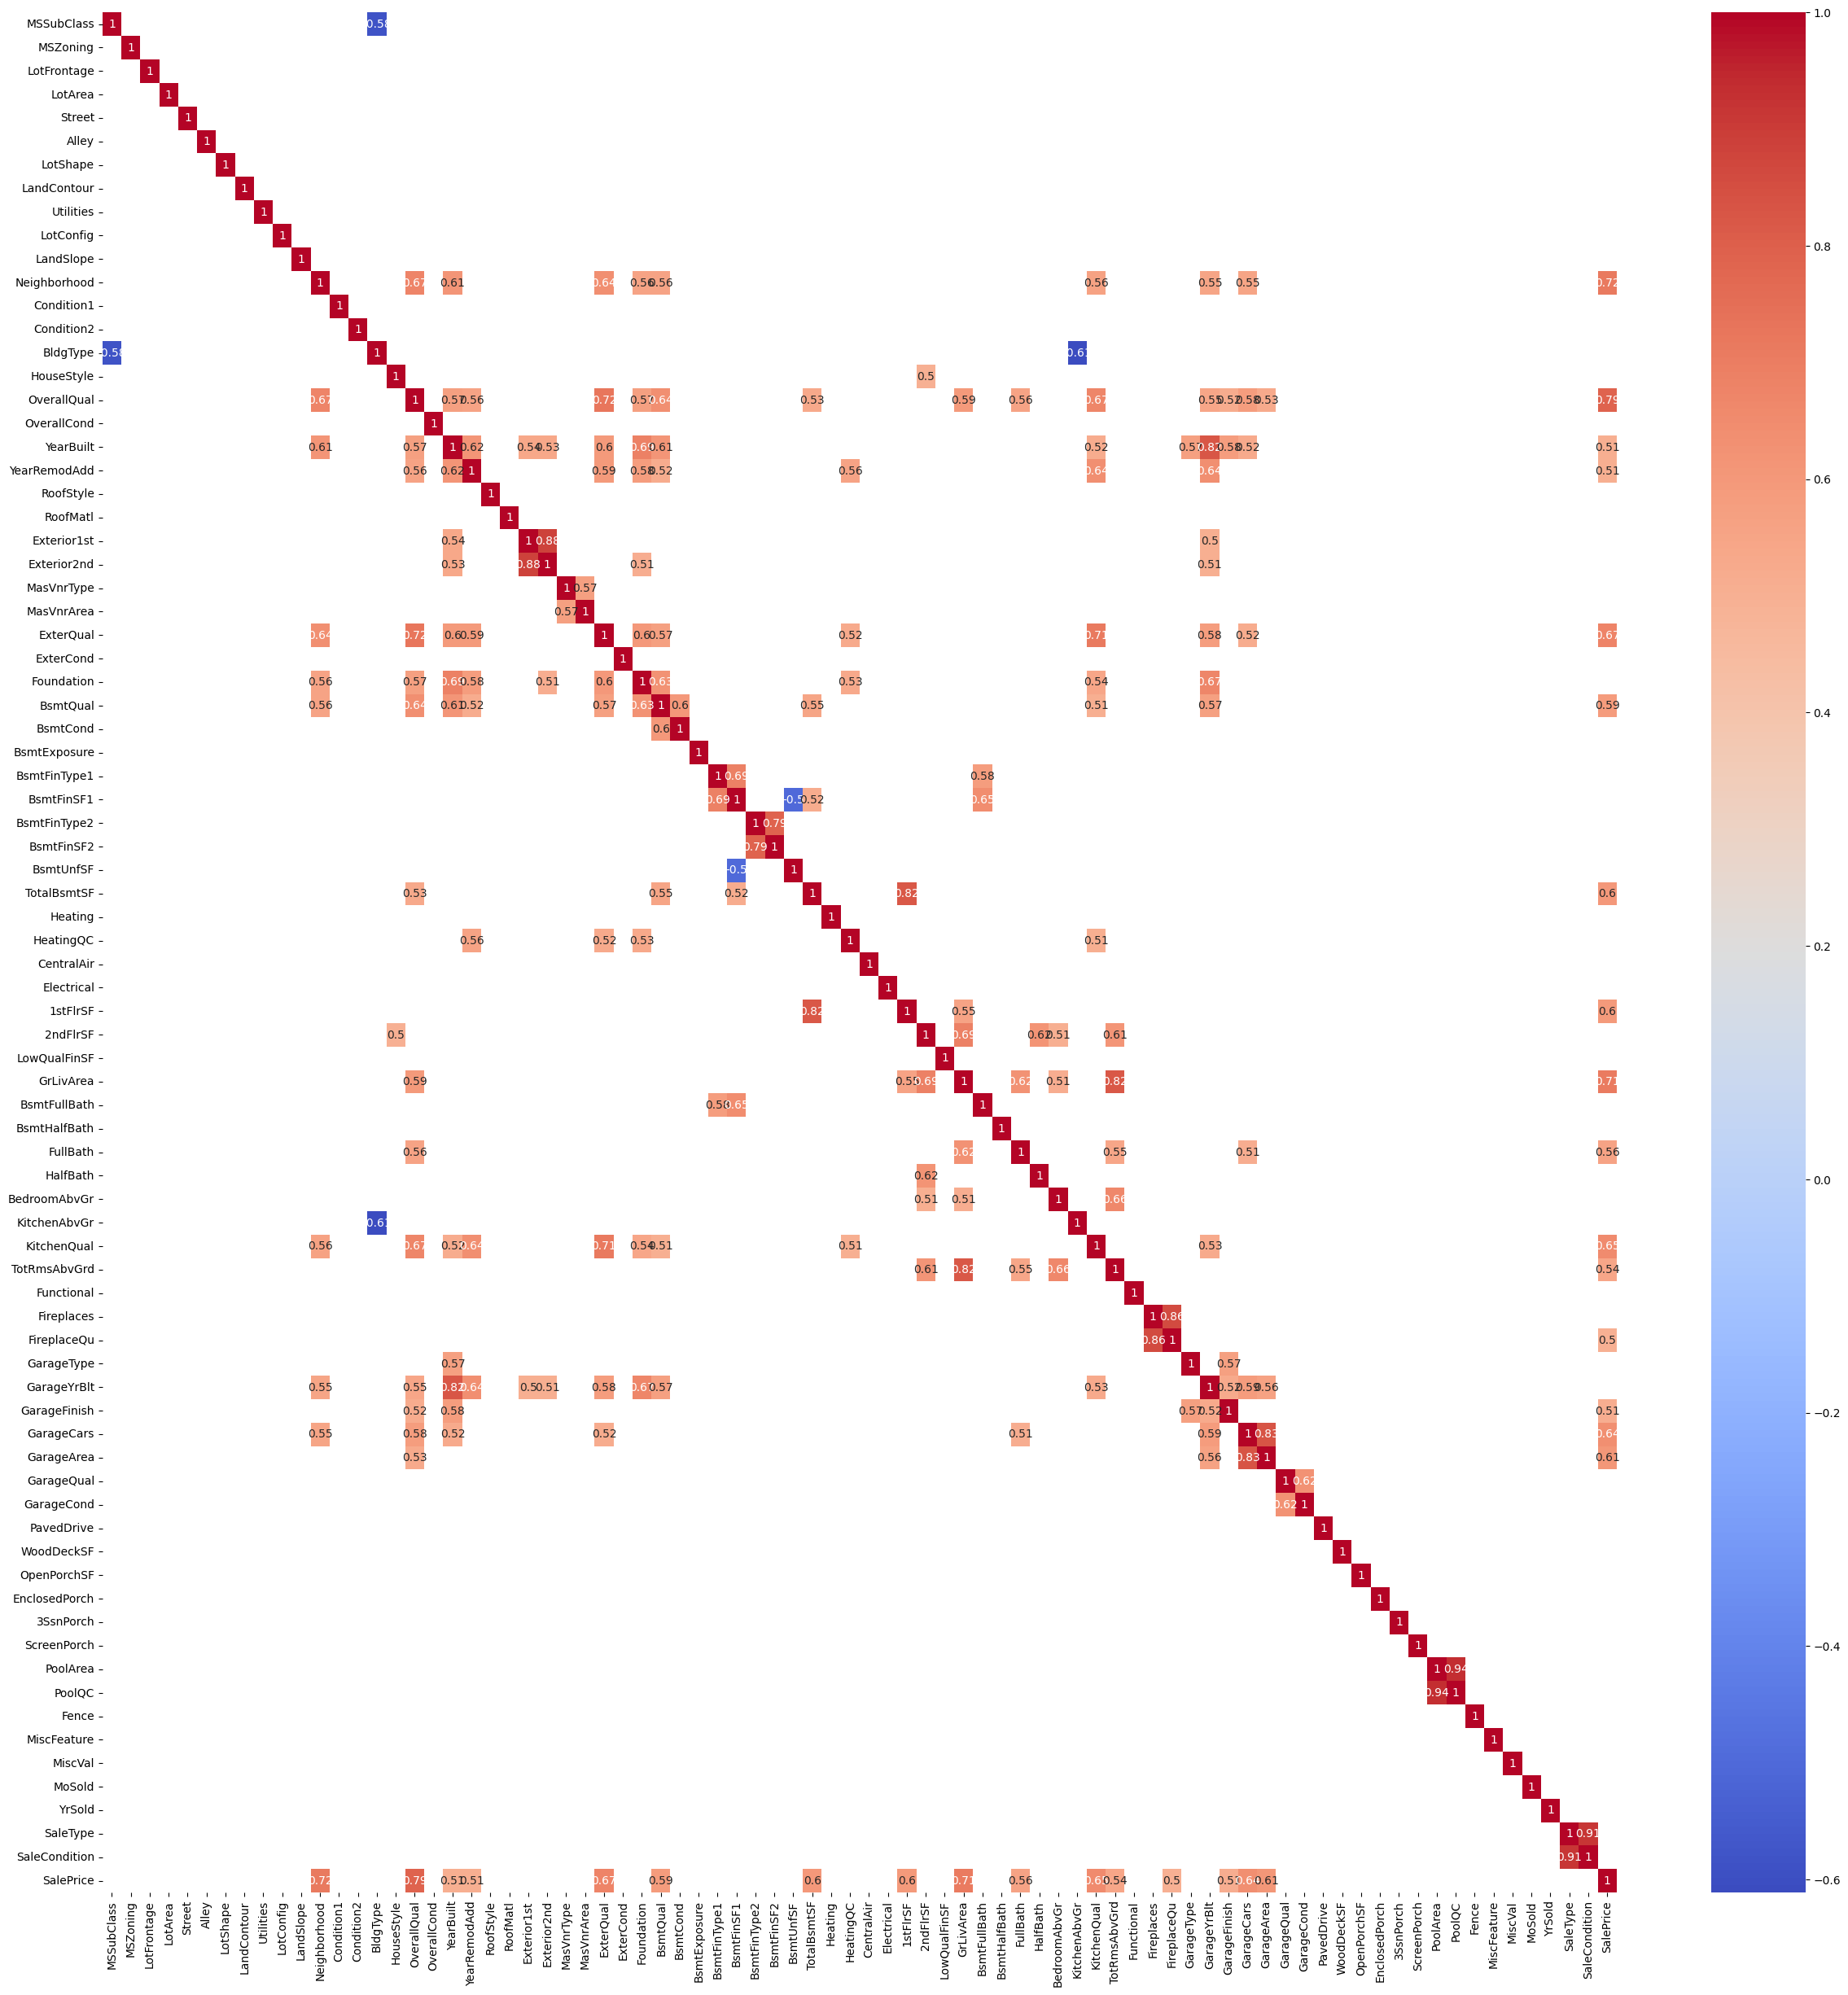

In [105]:
#Variáveis lineares
threshold_corr=0.5
corr_pearson = df.corr(method='pearson')
corr_pearson = corr_pearson[corr_pearson.abs()> threshold_corr]
plt.figure(figsize=(30, 30))
sn.heatmap(corr_pearson,annot=True,cmap='coolwarm')
plt.show()

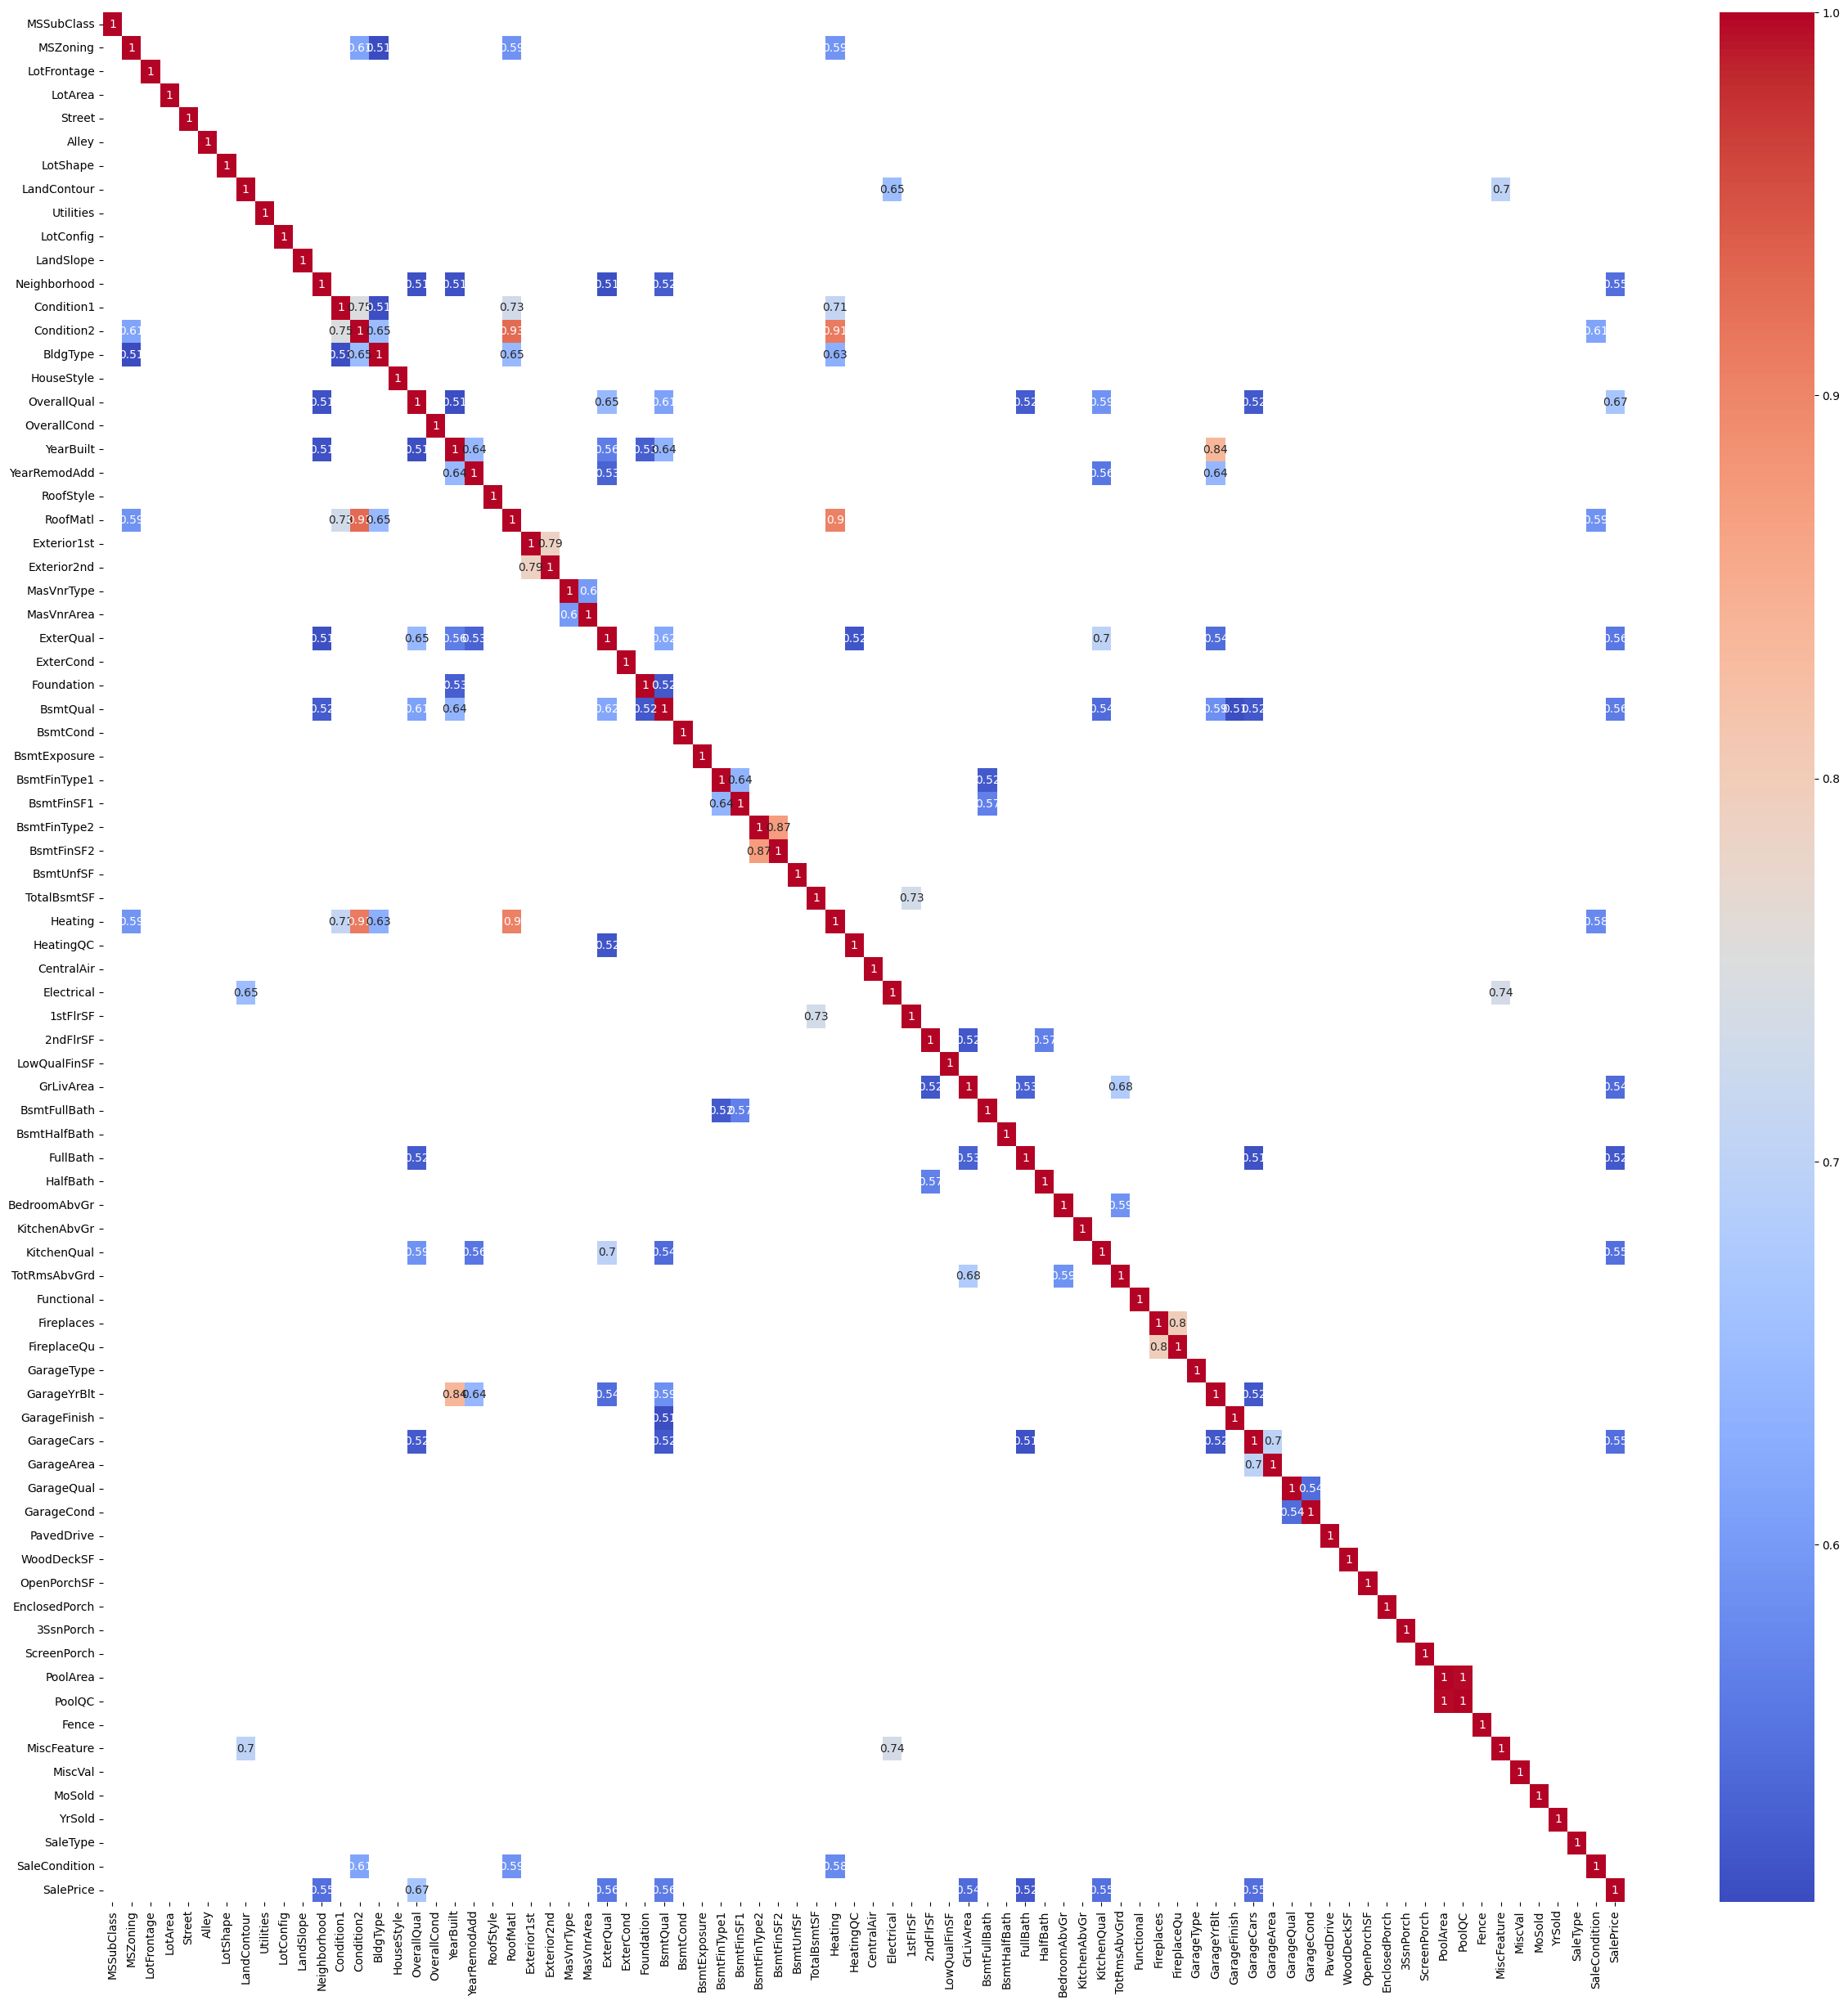

In [106]:
#Variáveis ordinal e categoricas
corr_kendall = df.corr(method='kendall')
corr_kendall = corr_kendall[corr_kendall.abs()> threshold_corr]
plt.figure(figsize=(30, 30))
sn.heatmap(corr_kendall,annot=True,cmap='coolwarm')
plt.show()

Importância

In [107]:
#Random Forest importance

rf = RandomForestRegressor()
x = df.drop(columns=['SalePrice'])
y = df['SalePrice']
rf.fit(x,y)
importances = np.round(rf.feature_importances_,4)

feature_names = df.columns
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = np.array(feature_names)[indices]

importance_df = pd.DataFrame({
    'Feature': sorted_feature_names,
    'Importance': sorted_importances
})
importance_df

,Feature,Importance
0,OverallQual,0.5532
1,GrLivArea,0.1103
2,Neighborhood,0.0608
3,TotalBsmtSF,0.0365
4,2ndFlrSF,0.0307
...,...,...
74,LowQualFinSF,0.0000
75,Utilities,0.0000
76,Street,0.0000
77,MiscVal,0.0000


In [108]:
#Permutation importance

results = permutation_importance(rf,x,y,scoring='neg_mean_squared_error')
importances = results.importances_mean
#Normalizar e arredondar valores
importances = np.round((importances / importances.sum()),4)
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = np.array(feature_names)[indices]

importance_df = pd.DataFrame({
    'Feature': sorted_feature_names,
    'Importance': sorted_importances
})
importance_df


,Feature,Importance
0,OverallQual,0.4757
1,GrLivArea,0.2147
2,Neighborhood,0.0626
3,TotalBsmtSF,0.0410
4,BsmtFinSF1,0.0287
...,...,...
74,LowQualFinSF,0.0000
75,Utilities,0.0000
76,Street,0.0000
77,MiscVal,0.0000


# Outlier Detection e grid search

Outlier detection

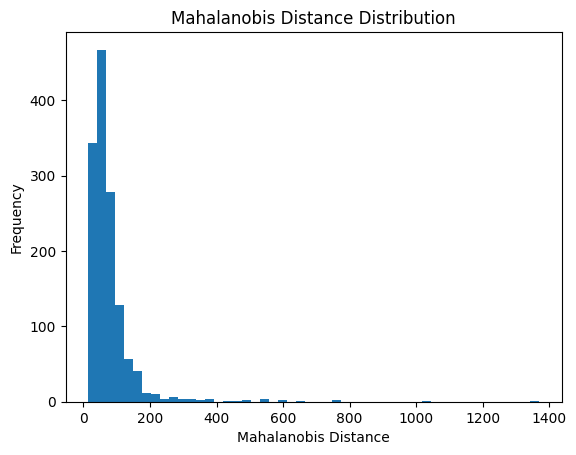

      MSSubClass       MSZoning  LotFrontage  LotArea  Street  Alley  \
0             60  189860.788660         65.0     8450       1     -1   
1             20  191004.994787         80.0     9600       1     -1   
2             60  189860.788660         68.0    11250       1     -1   
3             70  189860.788660         60.0     9550       1     -1   
4             60  191004.994787         84.0    14260       1     -1   
...          ...            ...          ...      ...     ...    ...   
1455          60  189860.788660         62.0     7917       1     -1   
1456          20  189860.788660         85.0    13175       1     -1   
1457          70  191004.994787         66.0     9042       1     -1   
1458          20  191004.994787         68.0     9717       1     -1   
1459          20  191004.994787         75.0     9937       1     -1   

      LotShape    LandContour  Utilities      LotConfig  ...  PoolArea  \
0            3  178337.576310          3  179834.479290  ... 

In [113]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
cov_model = EmpiricalCovariance().fit(df_scaled)
distances = cov_model.mahalanobis(df_scaled)

df_without_outlier = df.copy()
#Acrescentar temporáriamente uma coluna com as mahanalobis distances
df_without_outlier['Mahalanobis_Distance'] = distances

threshold_outlier = np.percentile(distances,95)

df_without_outlier['Outlier'] = df_without_outlier['Mahalanobis_Distance'] > threshold_outlier

plt.hist(df_without_outlier['Mahalanobis_Distance'], bins=50)
plt.title('Mahalanobis Distance Distribution')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.show()

#Quando outlier é true ~ transforma em false e não vai para o outlier
df_without_outlier = df_without_outlier[~df_without_outlier['Outlier']].drop(columns=['Mahalanobis_Distance', 'Outlier'])
print(df)
print(df_without_outlier)

# Implementação de Bayesian optimization para hyperparâmetros

Definir K-Fold para avaliação

In [ ]:
def KFold_metrics(df,model,k,metric):
    x = np.array(df.drop(columns=['SalePrice']))
    y = np.array(df['SalePrice'])
    kf = KFold(n_splits=k)
    PRED = None
    TRUTH = None
    for Train_Index, Test_Index in kf.split(x,y):
        X_Train,X_Test = x[Train_Index],x[Test_Index]
        Y_Train,Y_Test = y[Train_Index],y[Test_Index]
        model.fit(X_Train,Y_Train)
        prediction = model.predict(X_Test)
        if (PRED is None or TRUTH is None):
            PRED = prediction
            TRUTH = Y_Test
        else:
            PRED = np.hstack((PRED,prediction))
            TRUTH = np.hstack((TRUTH,Y_Test))
    return metric(TRUTH,PRED)

Bayesian optimization

In [121]:
def objective_function(params):
    n_features_to_select, n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree = params
    model = XGBRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        min_samples_split=min_child_weight,  
        subsample=subsample, 
        max_features=colsample_bytree
    )

    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
    pipe = Pipeline([('rfe',rfe),('model',model)])
    #Para sem outliers por agora
    return KFold_metrics(df,pipe,10,root_mean_squared_error)

search_space = [
    Integer(40, 75, name='rfe__n_features_to_select'),  
    Categorical([100, 200, 300, 400, 500], name='model__n_estimators'),  
    Categorical([0.01, 0.05, 0.1, 0.2, 0.3], name='model__learning_rate'),  
    Categorical([3, 5, 7, 9, 11], name='model__max_depth'), 
    Categorical([1, 3, 5, 7], name='model__min_child_weight'),  
    Real(0.7, 1.0, name='model__subsample'),  
    Real(0.7, 1.0, name='model__colsample_bytree')  
]

result = gp_minimize(
    func=objective_function,
    dimensions=search_space,
    n_calls=1000,  # Number of function evaluations
    random_state=42
)

print("Best parameters found: ", result.x)
print("Best score: ", -result.fun)

Melhores hyperparameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 500, 'model__subsample': 0.85}


In [ ]:
#Fazer pipeline com recursive feature deleting and xgboost regressor sem outliers
x = np.array(df.drop(columns=['SalePrice']))
y = np.array(df['SalePrice'])

xgb = XGBRegressor(objective='reg:squarederror',eval_metric='rmse',random_state=42)
pipe = Pipeline([('rfe',RFE(estimator=xgb,n_features_to_select=65)),
                 ('model',xgb)])
param_grid = { 
    'model__n_estimators': [100, 200, 300, 400, 500],           
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],        
    'model__max_depth': [3, 5, 7, 9, 11],                  
    'model__min_child_weight': [1, 3, 5, 7],          
    'model__subsample': [0.7, 0.85, 1.0],              
    'model__colsample_bytree': [0.7, 0.85,  1.0],     
}  
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(x, y)

print(f"Melhores hyperparameters: {grid_search.best_params_}")

# Treino e teste

Modelos

In [115]:
#XGB sem qualquer feature selection ou parametros
xgb_simples = XGBRegressor(random_state=42) 
print(KFold_metrics(df,xgb_simples,10,root_mean_squared_error))


#XGB com feature selection usando Recursive Feature Elimination
pipeline1= Pipeline([('rfe',RFE(n_features_to_select=65,estimator=xgb_simples)),('xgb',xgb_simples)])
print(KFold_metrics(df,pipeline1,10,root_mean_squared_error))

#XGB com RFE e hyperparameters para com outliers
xgb_tuned = XGBRegressor(random_state = 42, colsample_bytree=0.7, learning_rate=0.05,max_depth=3,min_child_weight=1,n_estimators=500,subsample=0.85)
pipeline2 = Pipeline([('rfe',RFE(n_features_to_select=65,estimator=xgb_tuned)),('xgb',xgb_tuned)])
print(KFold_metrics(df,pipeline2,10,root_mean_squared_error))

#XGB com RFE e hyperparameters sem outliers
print(KFold_metrics(df_without_outlier,pipeline2,10,root_mean_squared_error))

27561.060436026
27413.227341681843
25869.867177312146
21861.0751532067
